In [561]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sensors import mse, dict2vect, vect2dict
from scipy import sparse
from multiprocess import Pool 
import heapq
from tqdm.notebook import tqdm
from scipy.linalg import lu_factor, lu_solve

In [775]:
G = nx.path_graph(10)

In [797]:
def transition_matrix(G):
    A = np.array(nx.adjacency_matrix(G).todense())
    D_inv = np.diag([1 / x for x in np.sum(A, axis=0)])
    return np.dot(D_inv, A)

In [528]:
def synthetic_speeds(G):
    eigs = np.linalg.eig(nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=nx.line_graph(G).nodes()).toarray())
    order = np.argsort(eigs[0])
    
    vals = eigs[1][:,-1]
    speeds = {}
    for i, v in enumerate(nx.line_graph(G).nodes()):
        speeds[v] = vals[i]
    return speeds

In [888]:
import random

random.seed(3)

def weightedL2(a, b, w):
    q = a-b
    return (w*q*q).sum()

def choose_sensors_sparse(G, labeled_edges, weights, k=None, debug=False):
    if k == None:
        k = int(G.number_of_edges() / 10)
        
    m = G.number_of_edges()
    
    line_G = nx.line_graph(G)
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    x = np.array([labeled_edges[reverse[v]] for v in range(m)])
    w = np.array([weights[reverse[v]] for v in range(m)])
    
    # Choose random sensors
    C = [mapping[k] for k in labeled_edges]
    S = random.sample(C, k)
    T = sorted(list(set(C) - set(S)))
    
    # Initial prediction
    P = sparse.csc_matrix(transition_matrix(line_G))
    P_TT = P[np.ix_(T, T)]
    P_TS = P[np.ix_(T, S)]

    lu = sparse.linalg.splu(sparse.identity(m-k, format="csc") - P_TT)

    x_S = x[np.ix_(S)]
    x_T_hat = lu.solve(P_TS @ x_S)
    
    current_err = weightedL2(x_T_hat, x[np.ix_(T)], w[np.ix_(T)])
    old_err = float("inf")
    iteration = 0
    
    while old_err - current_err > 1e-5:
        old_err = current_err
        
        if debug:
            print("iteration {} current error {:e}".format(iteration, current_err))
        
        for i in range(k):
            # Move sensor i to a more optimal placement
#             subgraph = [v for v in line_G.neighbors(S[i])] 
#             nbrs = list(set(subgraph).intersection(set(C)).difference(set(S)))
            candidates = random.sample(list(set(C).difference(set(S))), min(10, len(C) - len(S)))
            
            for v in candidates:
                S_prime = S[:i] + [v] + S[i+1:]
                swap = np.where(np.array(T) == v)[0][0]
                T_prime = T[:swap] + [S[i]] + T[swap+1:]
                
                P_TT_prime = P[np.ix_(T_prime, T_prime)]
                
                P_TS_prime = P[np.ix_(T_prime, S_prime)]
                x_S_prime = x[np.ix_(S_prime)]
                
                U = np.zeros((m-k, 2))
                U[:, 1] = P_TT.toarray()[:, swap] - P_TT_prime.toarray()[:, swap]
                U[swap] = [1, 0]
                
                V = np.zeros((2, m-k))
                V[0] = P_TT.toarray()[swap] - P_TT_prime.toarray()[swap]
                V[:, swap] = [0, 1]
                
#                 if not np.allclose(P_TT - U @ V, P_TT_prime):
#                     print("Invalid rank 2 update:")
#                     print(P_TT - P_TT_prime)
#                     print(U @ V)
                
                x_int = lu.solve(P_TS_prime @ x_S_prime)
                Y = lu.solve(U)
                
                # the sparse version
                x_int = sparse.csc_array(x_int).transpose()
                Y = sparse.csc_matrix(Y)
                V = sparse.csc_matrix(V)
                x_T_prime_sparse = x_int - Y @ sparse.linalg.inv(sparse.identity(2, format="csc") + V @ Y) @ V @ x_int
                
#                 if not np.allclose(x_T_prime, x_T_prime_sparse.toarray()):
#                     print(x_T_prime)
#                     print(x_T_prime_sparse)
#                     print(x_T_prime - x_T_prime_sparse.toarray().transpose())
#                     return
                
                # If error decreased, keep the swap
                new_err = weightedL2(x_T_prime_sparse.transpose().toarray(), x[np.ix_(T_prime)], w[np.ix_(T_prime)])
                if new_err < current_err:
                    # New sensor and target sets
                    current_err = new_err
                    S = S_prime
                    T = T_prime
                    P_TT = P_TT_prime
                    
                    # Recompute LU decomposition
                    lu = sparse.linalg.splu(sparse.identity(m-k, format="csc") - P_TT)
                    # print(np.linalg.matrix_rank(np.identity(m-k) - P_TT))
                        
        if debug:
            print("end of iteration {} improvement {:e}".format(iteration, old_err - current_err))
        iteration += 1
    return [reverse[s] for s in S]

choose_sensors_sparse(G, synthetic_speeds(G), {e: 1 for e in G.edges()}, k=3, debug=True)

iteration 0 current error 1.199726e+00
end of iteration 0 improvement 1.161672e+00
iteration 1 current error 3.805387e-02
end of iteration 1 improvement 0.000000e+00


[(0, 1), (8, 9), (4, 5)]

In [843]:
import random

random.seed(3)

def weightedL2(a, b, w):
    q = a-b
    return (w*q*q).sum()

def choose_sensors_lu(G, labeled_edges, weights, k=None, debug=False):
    if k == None:
        k = int(G.number_of_edges() / 10)
        
    m = G.number_of_edges()
    
    line_G = nx.line_graph(G)
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    x = np.array([labeled_edges[reverse[v]] for v in range(m)])
    w = np.array([weights[reverse[v]] for v in range(m)])
    
    # Choose random sensors
    C = [mapping[k] for k in labeled_edges]
    S = random.sample(C, k)
    T = sorted(list(set(C) - set(S)))
    
    # Initial prediction
    P = transition_matrix(line_G)
    P_TT = P[np.ix_(T, T)]
    P_TS = P[np.ix_(T, S)]

    lu, piv = lu_factor(np.identity(m-k) - P_TT)

    x_S = x[np.ix_(S)]
    x_T_hat = lu_solve((lu, piv), P_TS @ x_S)
    
    current_err = weightedL2(x_T_hat, x[np.ix_(T)], w[np.ix_(T)])
    old_err = float("inf")
    iteration = 0
    
    while old_err - current_err > 1e-5:
        old_err = current_err
        
        if debug:
            print("iteration {} current error {:e}".format(iteration, current_err))
        
        for i in range(k):
            # Move sensor i to a more optimal placement
            subgraph = [v for v in line_G.neighbors(S[i])] 
            nbrs = list(set(subgraph).intersection(set(C)).difference(set(S)))
            candidates = random.sample(nbrs, min(10, len(nbrs)))
            
            for v in candidates:
                S_prime = S[:i] + [v] + S[i+1:]
                swap = np.where(np.array(T) == v)[0][0]
                T_prime = T[:swap] + [S[i]] + T[swap+1:]
                
                P_TT_prime = P[np.ix_(T_prime, T_prime)]
#                 P_TT_prime = np.copy(P_TT)
#                 row = P[v][T_prime]
#                 col = P[:, v][T_prime]
#                 P_TT_prime[swap] = row
#                 P_TT_prime[:, swap] = col
                
                P_TS_prime = P[np.ix_(T_prime, S_prime)]
                x_S_prime = x[np.ix_(S_prime)]
                
                U = np.zeros((m-k, 2))
                U[:, 1] = P_TT[:, swap] - P_TT_prime[:, swap]
                U[swap] = [1, 0]
                
                V = np.zeros((2, m-k))
                V[0] = P_TT[swap] - P_TT_prime[swap]
                V[:, swap] = [0, 1]
                
#                 if not np.allclose(P_TT - U @ V, P_TT_prime):
#                     print("Invalid rank 2 update:")
#                     print(P_TT - P_TT_prime)
#                     print(U @ V)
                
                x_int = lu_solve((lu, piv), P_TS_prime @ x_S_prime)
                Y = scipy.linalg.lu_solve((lu, piv), U)
                x_T_prime = x_int - Y @ np.linalg.inv(np.identity(2) + V @ Y) @ V @ x_int
                
                # If error decreased, keep the swap
                new_err = weightedL2(x_T_prime, x[np.ix_(T_prime)], w[np.ix_(T_prime)])
                if new_err < current_err:
                    # New sensor and target sets
                    current_err = new_err
                    S = S_prime
                    T = T_prime
                    P_TT = P_TT_prime
                    
                    # Recompute LU decomposition
                    lu, piv = lu_factor(np.identity(m-k) - P_TT)
                    # print(np.linalg.matrix_rank(np.identity(m-k) - P_TT))
                        
        if debug:
            print("end of iteration {} improvement {:e}".format(iteration, old_err - current_err))
        iteration += 1
    return [reverse[s] for s in S]

choose_sensors_lu(G, synthetic_speeds(G), {e: 1 for e in G.edges()}, k=3, debug=True)

iteration 0 current error 1.199726e+00
end of iteration 0 improvement 7.435915e-01
iteration 1 current error 4.561340e-01
end of iteration 1 improvement 3.717153e-01
iteration 2 current error 8.441870e-02
end of iteration 2 improvement 4.636483e-02
iteration 3 current error 3.805387e-02
end of iteration 3 improvement 0.000000e+00


[(8, 9), (4, 5), (0, 1)]

In [613]:
import random

random.seed(3)

def choose_sensors_lsmr(G, labeled_edges, weights, k=None, debug=False):        
    m = G.number_of_edges()
    
    if k == None:
        k = int(m / 10)
    
    line_G = nx.line_graph(G)
    mapping = dict(zip(line_G.nodes(), range(m)))
    reverse = dict(zip(range(m), line_G.nodes()))
    nx.relabel_nodes(line_G, mapping, copy=False)
    x = np.array([labeled_edges[reverse[v]] for v in line_G.nodes()])
    w = np.array([weights[reverse[v]] for v in line_G.nodes()])
    
    # Choose random sensors
    C = [mapping[k] for k in labeled_edges]
    S = C[:k]
    T = sorted(list(set(C) - set(S)))
    
    # Initial prediction
    P = transition_matrix(line_G)
    P_TT = P[np.ix_(T, T)]
    P_TS = P[np.ix_(T, S)]

    x_S = x[np.ix_(S)]
    x_T_hat = sparse.linalg.lsmr(np.identity(m-k) - P_TT, P_TS @ x_S)[0]
    
    current_err = weightedL2(x_T_hat, x[np.ix_(T)], w[np.ix_(T)])
    old_err = float("inf")
    iteration = 0
    
    while old_err - current_err > 1e-5:
        old_err = current_err
        
        if debug:
            print("iteration {} current error {:e}".format(iteration, current_err))
        
        for i in range(k):
            # Move sensor i to a more optimal placement
            subgraph = nx.ego_graph(line_G, S[i], 1)
            nbrs = list(set(subgraph.nodes()).intersection(set(C)).difference(set(S)))
            candidates = random.sample(nbrs, min(10, len(nbrs)))
            
            for v in candidates:
                S_prime = S[:i] + [v] + S[i+1:]
                T_prime = T[:swap] + [S[i]] + T[swap+1:]
                
                P_TT_prime = np.copy(P_TT)
                row = P[v][T_prime]
                col = P[:, v][T_prime]
                P_TT_prime[swap] = row
                P_TT_prime[:, swap] = col
                
                P_TS_prime = P[np.ix_(T_prime, S_prime)]
                x_S_prime = x[np.ix_(S_prime)]
                
                x_T_prime = sparse.linalg.lsmr(np.identity(m-k) - P_TT_prime, P_TS_prime @ x_S_prime)[0]
                
                # Check correctness
#                 if not np.allclose((np.identity(m-k) - P_TT_prime) @ x_T_prime, P_TS_prime @ x_S_prime):
#                     print("Update error: invalid least squares solution. SSE: ")
#                     print(np.linalg.norm((np.identity(m-k) - P_TT_prime) @ x_T_prime - P_TS_prime @ x_S_prime))
#                     return
                
                # If error decreased, keep the swap
                new_err = weightedL2(x_T_prime, x[np.ix_(T_prime)], w[np.ix_(T_prime)])
                if new_err < current_err:
                    # New sensor and target sets
                    current_err = new_err
                    S = S_prime
                    T = T_prime
                    P_TT = P_TT_prime
                        
        if debug:
            print("end of iteration {} improvement {:e}".format(iteration, old_err - current_err))
        iteration += 1
    return [reverse[s] for s in S]

choose_sensors_lsmr(G, synthetic_speeds(G), {e: 1 for e in G.edges()}, k=3, debug=True)

iteration 0 current error 8.863686e-01
end of iteration 0 improvement 2.357734e-01
iteration 1 current error 6.505952e-01
end of iteration 1 improvement 1.616411e-01
iteration 2 current error 4.889541e-01
end of iteration 2 improvement 0.000000e+00


[(0, 1), (8, 9), (6, 7)]

## Traffic Networks

In [439]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ")
    flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    speeds = synthetic_speeds(G)
    return G, flows, speeds

In [924]:
Berlin = nx.from_pandas_edgelist(pd.read_csv("data/Berlin-Tiergarten/berlin-tiergarten_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
EMA = nx.from_pandas_edgelist(pd.read_csv("data/Eastern-Massachusetts/EMA_net.tntp", sep="\t", skiprows=8), 
                            source="init_node", target="term_node")
LA = nx.from_pandas_edgelist(pd.read_csv("out/small.results.csv"), source="edge_from", target="edge_to")

In [584]:
speeds = synthetic_speeds(Berlin)
weights = {e: 1 for e in Berlin.edges()}

In [615]:
%timeit choose_sensors_lu(Berlin, speeds, weights, k=20)
%timeit choose_sensors_lsmr(Berlin, speeds, weights, k=20)

323 ms ± 70.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.6 s ± 1.63 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [527]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [889]:
%lprun -f choose_sensors_sparse choose_sensors_sparse(Berlin, speeds, weights, k=int(Berlin.number_of_edges() / 5))

In [515]:
%prun -s cumulative choose_sensors_lsmr(Berlin, synthetic_speeds(Berlin), {e: 1 for e in Berlin.edges()}, k=20)

In [851]:
import time

def get_speedups(G, flows, speeds, ratio, samples=50):
    m = G.number_of_edges()
    k = int(m * ratio)
    
    sparse, lu, lsmr = {}, {}, {}
        
    for j in tqdm(range(1, samples + 1)):
        i = int(k * j / samples)
        
        t = time.process_time_ns()
        choose_sensors_sparse(G, speeds, flows, k=k)
        sparse[i / m] = time.process_time_ns() - t
        
        t = time.process_time_ns()
        choose_sensors_lu(G, speeds, flows, k=k)
        lu[i / m] = time.process_time_ns() - t
        
        t = time.process_time_ns()
        choose_sensors_lsmr(G, speeds, flows, k=k)
        lsmr[i / m] = time.process_time_ns() - t
        
    return {
        "sparse": sparse,
        "lu": lu,
        "lsmr": lsmr
    }

In [852]:
speedups = get_speedups(Berlin, {e: 1 for e in Berlin.edges()}, synthetic_speeds(Berlin), .1)

  0%|          | 0/50 [00:00<?, ?it/s]

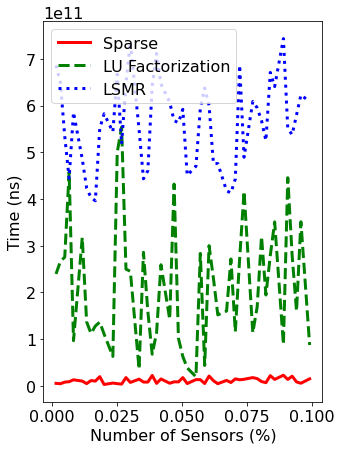

In [859]:
fig, ax = plt.subplots(figsize=(5, 7))

def plot_speedups(speedups, ax):
    ax.plot(speedups["sparse"].keys(), speedups["sparse"].values(), "r", label="Sparse",
           linewidth=3)
    ax.plot(speedups["lu"].keys(), speedups["lu"].values(), "g", label="LU Factorization",
           linewidth=3, linestyle="dashed")
    ax.plot(speedups["lsmr"].keys(), speedups["lsmr"].values(), "b", label="LSMR",
           linewidth=3, linestyle="dotted")
    ax.legend()
    ax.set_xlabel("Number of Sensors (%)")
    ax.set_ylabel("Time (ns)")
    
plot_speedups(speedups, ax)

In [484]:
from sklearn.cluster import SpectralClustering

def spectral_clustering_speeds(G, k):
    '''
        Graph should be undirected.
        Node ids should be integers starting from 0.
    '''
    line_graph = nx.line_graph(G.to_undirected(), create_using=nx.Graph())
    
    A = nx.to_numpy_array(line_graph)
    sc = SpectralClustering(n_clusters=k, assign_labels='discretize', affinity='precomputed', random_state=0).fit(A)
    membership = sc.labels_
    nodes = list(line_graph.nodes())
    selected = []
    
    for i in range(k):
        part = np.argwhere(np.array(membership) == i).ravel()

        #selecting a random node in the partition
        if len(part) > 0:
            selected.append(np.random.choice(part))
        else:
            selected.append(np.random.choice(list(set(range(len(membership))) - set(selected))))
                
    return [nodes[u] for u in selected]

In [485]:
def flow_weighted_error(flows):
    def evaluate(pred, labels):
        err = 0
        for k, v in labels.items():
            err += (flows[k] * (v - pred[k])) ** 2
        return err
    
    return evaluate

In [868]:
def speed_prediction(G, labelled_flows, lamb=1e-6, x0=None):
    '''
        Speed prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    line_G = nx.line_graph(G)
    
    A = nx.adjacency_matrix(line_G)
    f0 = []
    
    A.data = A.data / np.repeat(np.add.reduceat(A.data, A.indptr[:-1]), np.diff(A.indptr))
   
    U = []
    L = []
    i = 0
    j = 0
    index = {}
    for e in line_G.nodes():
        if e in labelled_flows:
            f0.append(labelled_flows[e])
            L.append(i)
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    PUL = A[np.ix_(U, L)]
    f0 = np.array(f0)
    b = PUL.dot(f0)
    PUU = A[np.ix_(U, U)]
    A = scipy.sparse.identity(PUU.shape[0])-PUU   
    res = linalg.lsmr(A, b, damp=lamb, x0=x0)
    x = res[0]
    
    pred_flows = {}

    for e in G.edges:
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
            
    return pred_flows

In [920]:
def err(G, sensors, labels, i, error=mse):
    preds = speed_prediction(G, {s: labels[s] for s in sensors[:i]})
    return error(preds, labels)

In [921]:
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def flow_weighted_corr(G, flows):
    return lambda preds, labels: corr(dict2vect(G, preds), dict2vect(G, labels), dict2vect(G, flows))

In [890]:
from sensors import choose_sensors_random

def get_speed_results(G, flows, speeds, ratio, samples=50, debug=False):
    k = int(G.number_of_edges() * ratio)
    fwe = flow_weighted_error(flows)
    fwcorr = flow_weighted_corr(G, flows)
    
    random_sensors = choose_sensors_random(G, k)
    random_corr, greedy_corr, cluster_corr = {0: 0}, {0: 0}, {0: 0}
        
    for j in tqdm(range(1, samples + 1)):
        i = int(k * j / samples)
        
        cluster_sensors = spectral_clustering_speeds(G, i)
        greedy_sensors = choose_sensors_sparse(G, speeds, weights=flows, k=i, debug=debug)
        
        random_corr[i / G.number_of_edges()] = max(err(G, random_sensors, speeds, i, error=fwcorr), 0)
        greedy_corr[i / G.number_of_edges()] = max(err(G, greedy_sensors, speeds, i, error=fwcorr), 0)
        cluster_corr[i / G.number_of_edges()] = max(err(G, cluster_sensors, speeds, i, error=fwcorr), 0)
        
    return {
        "random": random_corr,
        "greedy": greedy_corr,
        "spectral": cluster_corr
    }

In [891]:
results = {}

In [892]:
results["Anaheim"] = get_speed_results(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), 1)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


In [896]:
results["Berlin"] = get_speed_results(Berlin, {e : 1 for e in Berlin.edges()}, speeds, 1)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


In [898]:
results["EMA"] = get_speed_results(EMA, {e : 1 for e in EMA.edges()}, synthetic_speeds(EMA), 1)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


In [899]:
results["LA"] = get_speed_results(LA, {e : 1 for e in LA.edges()}, synthetic_speeds(LA), 1)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


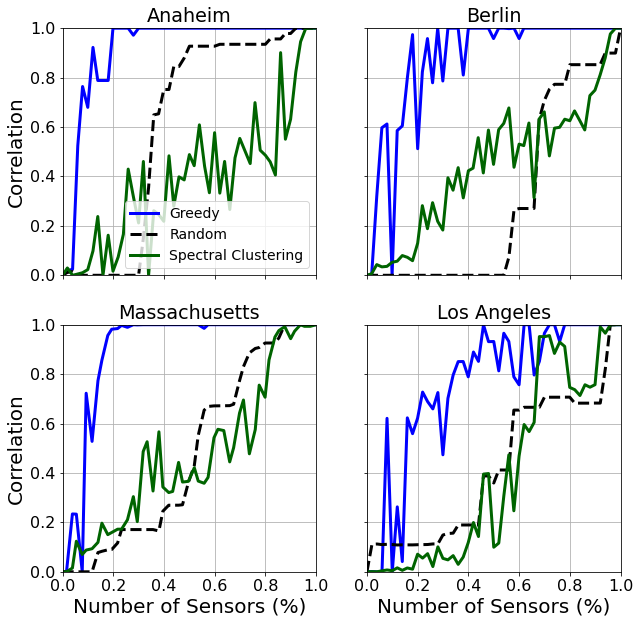

In [907]:
import matplotlib

def plot_speed_results(results, ax, title="", xlabel=False, ylabel=False, legend=False):
    ax.plot(results["greedy"].keys(), results["greedy"].values(), "b", label="Greedy",
           linewidth=3)
    ax.plot(results["random"].keys(), results["random"].values(), "black", label="Random",
           linewidth=3, linestyle="dashed")
    ax.plot(results["spectral"].keys(), results["spectral"].values(), "darkgreen", label="Spectral Clustering",
           linewidth=3)
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)
    
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_speed_results(results["Anaheim"], ax[0][0], title="Anaheim", ylabel=True, legend=True)
plot_speed_results(results["Berlin"], ax[0][1], title="Berlin")
plot_speed_results(results["EMA"], ax[1][0], title="Massachusetts", xlabel=True, ylabel=True)
plot_speed_results(results["LA"], ax[1][1], title="Los Angeles", xlabel=True)

plt.savefig("results/synthetic_speeds.pdf")

In [ ]:
import json

with open("data/Anaheim/anaheim_nodes.geojson") as f:
    features = json.loads(f.read())["features"]

coords = {}
for feat in features:
    coords[feat["properties"]["id"]] = feat["geometry"]["coordinates"]

plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw(G, coords, node_size=2, edge_color = ["green" if e in greedy_sensors[:50] else "black" for e in G.edges()],
       width = [5 if e in greedy_sensors[:50] else 1 for e in G.edges()])

In [ ]:
plt.figure(figsize=[3 * x for x in [6.4, 4.8]])
nx.draw(G, coords, node_size=2, edge_color = [flows[e] for e in G.edges()])

In [ ]:
preds = speed_prediction(G, {s: speeds[s] for s in greedy_sensors[:50]})
fwcorr(preds, speeds)

In [943]:
speeds = synthetic_speeds(Berlin)
sensors = choose_sensors_sparse(Berlin, speeds, {e: 1 for e in Berlin.edges()}, 
                                k=int(Berlin.number_of_edges() * .1))

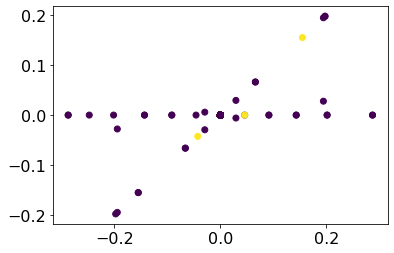

In [948]:
preds = speed_prediction(Berlin, {s: speeds[s] for s in sensors})
x = dict2vect(Berlin, speeds)
y = dict2vect(Berlin, preds)
plt.scatter(x, y, c = [1 if e in sensors else 0 for e in speeds])

In [938]:
np.corrcoef(dict2vect(Berlin, speeds), dict2vect(Berlin, preds))

array([[1.       , 0.8703746],
       [0.8703746, 1.       ]])